# A notebook to carry out calculations

In [1]:
import sympy as sym
import scipy as sp
import numpy as np
sym.init_printing()

import imp
tools = imp.load_source('tools', '../tools.py')

assert sym.__version__ == "1.0"
assert sp.__version__ == "0.19.0"
assert np.__version__ == "1.12.1"

In [2]:
#import matplotlib
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

font = {'size'   : 15,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [3]:
from scipy.optimize import brentq

Defining all our variables (with assumption that they are positive).

In [4]:
r, s, x, theta_r, alpha, H, beta, gamma, F = sym.symbols("r, s, x, theta_r, alpha, \
                                                          H, beta, gamma, F", positive=True)

In [5]:
# some values for the parameters
gamma_num = .5
beta_num = .5
alpha_num = .5 
theta_r_num = .2  # Quantity of horn in devalued Rhino
F_num = 10
a1_num = 7
H_num = 100

In [6]:
variables = {gamma: gamma_num, beta: beta_num, alpha: alpha_num, 
             theta_r:theta_r_num, F: F_num, H: H_num, r:.97}

The model
----------

In [ ]:
# the theta function
tools.theta(r, s)

In [ ]:
# the psi function
tools.psi(r, s)

In [ ]:
# gain
tools.gain(1), tools.gain(0)

In [ ]:
rs = np.linspace(0, 0.999, 100)
alphas = np.linspace(0, 1, 5)
gains = [[(H * tools.theta(r, s=0.2, theta_r=.3 ) ** (- alpha_v)).subs({H:10, r: r_v}) 
           for r_v in rs] for alpha_v in alphas]

In [ ]:
plt.figure(figsize=(10, 7))
for i, v in enumerate(alphas):
    plt.plot(rs, gains[i], label=r'$\alpha={}$'.format(v)) 
    plt.xlabel(r'$r$'); plt.ylabel(r'$H \theta(r,s)^{-\alpha}$')
    plt.legend()
plt.tight_layout()
plt.savefig('../images/alphas.pdf')

In [ ]:
# cost
tools.cost(1), tools.cost(0)

In [ ]:
gammas = np.linspace(0, 1, 5)
costs = [[(F * (-r_v + 1) ** beta * tools.psi(r_v, s=0.7) ** gamma_v).subs({F:5, beta: .95}) for r_v in rs]
         for gamma_v in gammas]

In [ ]:
plt.figure(figsize=(10, 7))
for i, v in enumerate(gammas):
    plt.plot(rs, costs[i], label=r'$\gamma={}$'.format(v)) 
    plt.xlabel(r'$r$'); plt.ylabel(r'$F(1-rx)^{\gamma} (1-r)^{\beta}$')
    plt.legend()
plt.tight_layout()
plt.savefig('../images/gammas.pdf')

In [ ]:
betas = np.linspace(0, 1, 5)
costs = [[(F * (-r_v + 1) ** beta_v * tools.psi(r_v, s=1) ** gamma).subs({F:5, gamma: .95}) for r_v in rs]
         for beta_v in betas]

In [ ]:
plt.figure(figsize=(10, 7))
for i, v in enumerate(betas):
    plt.plot(rs, costs[i], label=r'$\beta={}$'.format(v)) 
    plt.xlabel(r'$r$'); plt.ylabel(r'$F(1-rx)^{\gamma} (1-r)^{\beta}$')
    plt.legend()
plt.tight_layout()
#plt.show()

plt.savefig('../images/betas.pdf')

Utility
-------

In [ ]:
tools.utility()

In [ ]:
expr = H * (theta_r * r * (1 - s) - r + 1) * tools.theta(r, x) ** (-alpha) - \
       F * (1 - r * x) ** gamma * ((1 - r) ** beta * (-s + s/(1 -r) + 1))

In [ ]:
(tools.utility() - expr).simplify()

# Condition for $s=1$ to be stable:

In [ ]:
expr = tools.utility(1, 1) - tools.utility(0, 1)
stable_selective_condition = sym.Eq(expr.expand(), 0)
stable_selective_condition

In [ ]:
expr.subs({r:0})

In [ ]:
expr.subs({r:0.99})

numerical example
-------------------

In [ ]:
# some values for the parameters
gamma_num = 1
beta_num = 1
alpha_num = 1 
theta_r_num = .1  # Quantity of horn in devalued Rhino
F_num = 10
H_num = 100

In [ ]:
variables = {gamma: gamma_num, beta: beta_num, alpha: alpha_num, 
             theta_r:theta_r_num, F: F_num, H: H_num, r:0.1}

In [ ]:
strategies = np.linspace(0, 0.99, 100)

In [ ]:
utilities = [tools.utility(s, 1).subs(variables) for s in strategies]

plt.plot(strategies, utilities)

plt.xlabel("$s$"); plt.ylabel("$u(s, 1-s), (1, 0))$")
plt.show()

$s = 1$ is stable as $s=1$ has the highest utility in the population.

# Condition for $s=0$ to be stable:

In [ ]:
expr = tools.utility(0, 0) - tools.utility(1, 0)
stable_indiscrimate_condition = sym.Eq(expr.expand(), 0)
stable_indiscrimate_condition

In [ ]:
expr.collect(r).collect(H).collect(F)

In [ ]:
(expr.simplify().collect(r) / r)

In [ ]:
(expr.simplify().collect(r) / r).subs({r:0})

Limit behaviour as $r\to 1$:

In [ ]:
sym.limit(expr, r, 1)

# numerical example

In [ ]:
utilities = [tools.utility(s, 0).subs(variables) for s in strategies]

plt.plot(strategies, utilities)

plt.xlabel("$s$"); plt.ylabel("$u(s, 1-s), (0, 1))$")
plt.show()

$s = 0$ is not stable as $s=1$ has the highest utility in the population.

# Condition for $1>s^*>0$ to be stable:

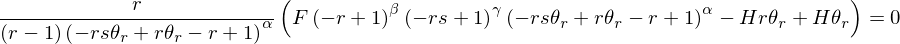

In [13]:
expr = tools.utility(1, s) - tools.utility(0, s)
stable_mixed_condition = sym.Eq(expr.simplify(), 0)
stable_mixed_condition

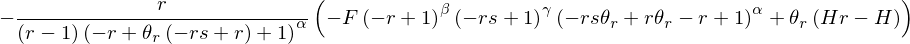

In [14]:
expr.factor().collect(theta_r).collect(r)

In [15]:
sym.init_printing(False)

In [16]:
expr.factor().collect(theta_r).collect(r)

-r*(-F*(-r + 1)**beta*(-r*s + 1)**gamma*(-r*s*theta_r + r*theta_r - r + 1)**alpha + theta_r*(H*r - H))*(-r + theta_r*(-r*s + r) + 1)**(-alpha)/(r - 1)

In preparation for numerical solution: let's see what the derivaties of the lhs of that are:

In [ ]:
sym.diff(expr, s)

In [ ]:
sym.diff(expr, s, 2)

# numerical example

In [ ]:
condition = stable_mixed_condition.lhs.subs(variables)
condition

In [ ]:
strategies = np.linspace(0, 1, 100)

In [ ]:
conds = [condition.subs({s:s_val}) for s_val in strategies]

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [ ]:
plt.plot(strategies, conds);
plt.title("$r=0.97$")
plt.ylabel("Left-hand side of (19)")
plt.xlabel("$s^*$")
plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

In [ ]:
# some values for the parameters
gamma_num = .95
beta_num = .95
alpha_num = .95 
theta_r_num = .1  # Quantity of horn in devalued Rhino
F_num = 10
H_num = 10

In [ ]:
expr.subs(variables)

In [ ]:
tools.s_star_v_r(gamma_num=0.5, beta_num=0.5, theta_r_num=0.2, H_num=500, F_num=1, stable_mixed_condition=expr)

In [ ]:
rs = np.linspace(0.0, .999, 100)
s_stars = [tools.s_star_v_r(gamma_num=0.95, 
                            beta_num=0.95, theta_r_num=0.2, H_num=500, F_num=100, stable_mixed_condition=expr) for r in rs]

In [ ]:
plt.scatter(rs, s_stars)
plt.xlabel("$r$", fontsize=18)
plt.ylabel("$s^*$", fontsize=18)
plt.ylim(0, 1);
plt.xlim(0, 1);
plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

plt.savefig('../images/stable_mixed_example.pdf')

In [ ]:
s_stars

In [ ]:
rs = np.linspace(0.0, .999, 100)

for theta_r_v in [*np.linspace(0, 1, 10)]:   
    
    s_stars = [tools.s_star_v_r(r, theta_r_num=theta_r_v) for r in rs]
    
    plt.figure();
    plt.scatter(rs, s_stars)
    plt.xlabel("$r$", fontsize=18)
    plt.ylabel("$s^*$", fontsize=18)
    plt.ylim(0, 1);
    plt.xlim(0, 1);
    plt.xticks(fontsize = 10);
    plt.yticks(fontsize = 10);
    plt.tight_layout();
    #plt.show()
    #plt.savefig("../images/stable_mixed_theta_r_{}.pdf".format(theta_r_v))

# Evolutionary stability

Here we test the evolutionary stability of the strategies. Let the strategy we know is stable and testing
it's evolytionary stability be $s^*$. For a strategy $s^*$ to be stable, it must be the best response in a mutated population. Let the mutation population be $s = s^* \pm \epsilon$.

$s^*$ is the best response if and only if:

$$u((s^*, 1 - s^*), (s, 1 -s)) > u((s, 1 - s), (s, 1 -s))$$

let:

$$ \delta_{\pm} = u((s^*, 1 - s^*), (s, 1 -s)) - u((s, 1 - s), (s, 1 -s))$$

In [ ]:
def evolutionary_stability(s, r_val=0.97, gamma_num=gamma_num, beta_num=beta_num, 
                           alpha_num=alpha_num, theta_r_num=theta_r_num, 
                           F_num=F_num, H_num=H_num,
                           tol=0.000001, step=0.0000001, starting_epsilon=0.00001):
    
    variables = {gamma: gamma_num, beta: beta_num, alpha: alpha_num, theta_r:theta_r_num, 
                 F: F_num, H: H_num, r:r_val}
    
    epsilon = starting_epsilon 
    
    evol_stable = []
    while epsilon > tol:
        
        up_s, down_s = min(s + epsilon, 1), max(s - epsilon, 0)
        delta_plus = (tools.utility(s, up_s) - tools.utility(up_s, up_s)).subs(variables)
        delta_minus = (tools.utility(s, down_s) - tools.utility(down_s, down_s)).subs(variables)
        
        evol_stable.append((delta_plus > tol) and (delta_minus > tol))
        epsilon -= step 
    
    return evol_stable, evol_stable[-1]

% Function with the condition of stability 

In [ ]:
evolutionary_stability(1, step=0.001, tol=0.00001, starting_epsilon=0.1)

In [ ]:
tools.evolutionary_stability(1, step=0.001, tol=0.00001, starting_epsilon=0.1)

%TODO evolutionary stability for s=1 for when s is stable.

$s ^ *$ a best response?
-----------------------

From the plot above we can tell that for an $r=0.6$ a $s^*$ for which the population is stable does exist.
Let us define the $s^*$ value.

In [ ]:
r_v = 0.6
s_star = s_star_v_r(r_v)
s_star

In [ ]:
evolutionary_stability(s_star, r_val=r_v, step=0.001, tol=0.00001, starting_epsilon=0.1)

In [ ]:
variables[r] = r_v

In [ ]:
tools.utility(s_star, s_star).subs(variables)

In [ ]:
epsilon = 0.5
tools.utility(s_star - epsilon, s_star).subs(variables)

In [ ]:
tools.utility(s_star, s_star - epsilon).subs(variables)

In [ ]:
tools.utility(s_star - epsilon, s_star - epsilon).subs(variables)

In [ ]:
tools.utility(s_star, s_star + epsilon).subs(variables)

In [ ]:
tools.utility(s_star + epsilon, s_star + epsilon).subs(variables)

In [ ]:
s_star_v_r(0.6)

In [ ]:
np.isnan(s_star_v_r(0.6))

In [ ]:
s_star_v_r(0.2) ==  np.nan #float('nan')

In [ ]:
s_star_v_r(0.6) == s_star_v_r(0.6)

In [ ]:
r_where_stable = [r for r in rs if not np.isnan(s_star_v_r(r))]

In [ ]:
r_where_stable

In [ ]:
last = [evolutionary_stability(s=s_star_v_r(r), r_val=r)[-1] for r in r_where_stable]

In [ ]:
last

In [ ]:
import itertools

In [ ]:
x, a, k = np.linspace(0, 1, 4), np.linspace(0, 0.1, 1), np.linspace(0, 2, 4)

In [ ]:
pairs = itertools.product(x, a, k)

In [ ]:
for i in pairs:
    print(i)

In [ ]:
xs = np.linspace(0, 1, 200)
beta = 0.5
ys = [(1-x) ** ((beta)) for x in xs]
plt.plot(xs, ys)

In [ ]:
xs = np.linspace(0, 1, 200)
alpha = 0.005
ys = [(1 - x) ** (-(alpha)) for x in xs]
plt.plot(xs, ys)